In [1]:
# Homework 3 (due 07/16/2024)

# Eigenbears

## Instructions

#### Part 1: Data preparation (ALREADY COMPLETED)
The folder that contains this notebook also contains a data set of pictures of pandas and brown bears. 
1. Load the images for train and test.
2. Reduce their size/resolution by 50%.
3. Convert the colors to grey scale.
4. Display a few of the images. 

#### Part 2: Singular value decomposition (FOR YOU TO COMPLETE)
1. Follow the steps in the eigenfaces tutorial from the UW databook [[link]](https://github.com/dynamicslab/databook_python/blob/master/CH01/CH01_SEC06_2_3_4.ipynb) to perform an SVD on the images.
2. Note that you will need to "center the data" before doing the SVD. Data centering means replacing each variable $X_i$ with a new variable $X_i'$ that is equal to $X_i$ minus $X_i$'s mean value. (Think carefully about whether you want to use the mean of train set, test set, or the full data set for this.)
3. Display the first four "eigenbears" (i.e., the images associated with the first four eigenvectors). Explain what you see.
4. The singular vectors are sometimes called "principal components". Principal component analysis (PCA) is a data analysis method for which one projects high-dimensional data into the subspace of the first two singular vectors. Use the code scaffold provided below do perform PCA for the bears data. What do you notice?

#### Part 3: Non-parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

#### Part 4: Parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Try using logistic regression and LDA to classify the bears. 
2. What method gives you the best test accuracy? 
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

--------------------------------

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, time
from sklearn.decomposition import PCA

## Part 1: Data preparation

In [3]:
# toggle settings
add_noise = True

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)
    

    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')
        
        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):
            
            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1
                
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
    
                # import image
                image = plt.imread(file_path, format='jpeg')
    
                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)
    
                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


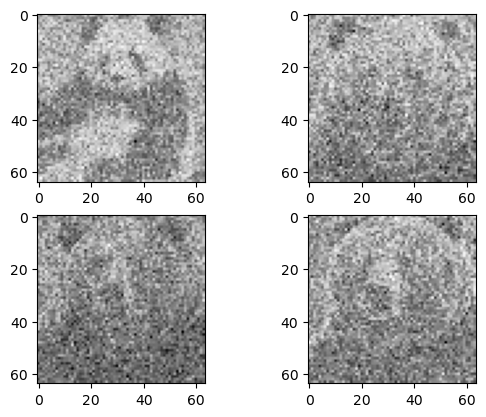

In [4]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

# Part 2: Singular value decomposition

In [5]:
train_images[1].shape

(128, 128)

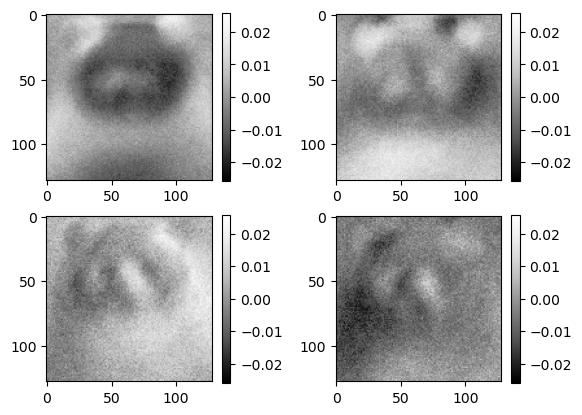

In [6]:
# Flatten each image and combine into one big array
flattened_images = [np.array(img).flatten() for img in train_images]
trainingFaces = np.column_stack(flattened_images)

# Construct data matrix of centered data
avgFace = np.mean(trainingFaces, axis=1, keepdims=True)  # size 1 by n*m (16384)

# Compute eigenfaces on mean-subtracted training data
X = trainingFaces - avgFace

# Flatten each image and combine into one big array
flattened_images_test = [np.array(img).flatten() for img in test_images]
testFaces = np.column_stack(flattened_images_test)

# Construct data matrix of centered data
avgtestFace = np.mean(testFaces, axis=1, keepdims=True)  # size 1 by n*m (16384)

# Compute eigenfaces on mean-subtracted training data
Y = testFaces - avgtestFace

# Perform SVD
U, S, Vh = np.linalg.svd(X)

# show the first four eigenbears
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow((U[:,i]).reshape((128,128)), cmap='Greys_r',
        # force colormap to be the same for all four
        vmin=-np.max(np.abs(U[:,:4])),
        vmax=np.max(np.abs(U[:,:4])))
    plt.colorbar()
plt.subplots_adjust(wspace=0.4)


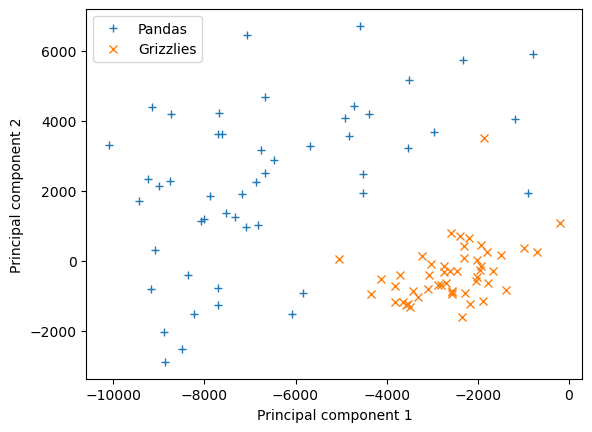

In [7]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:,0],np.ravel(test_images[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images[x])) for x in indices]
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Grizzlies'][i])

# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# add legend
plt.legend()

# Part 3: Nonparametric classification

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.
y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the 
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

In [10]:
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')
misclassified_bears = []
for k in range(1,16):
    # fit KNN model
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(X.T, y_train)
    # use model to make predictions on the test set
    predictions = [modelKN.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]
    # detect misclassifications
    errors = np.abs((np.array(predictions).T)[0]-y_test)
    # print results to table
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errors)), (np.argwhere(errors).T)[0]))
    
    misclassified_bears.append((np.argwhere(errors).T)[0])
    
print(misclassified_bears)

   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      8 	| [ 5  6  8 21 22 39 41 42]
    2	|      5 	| [ 8 21 22 39 42]
    3	|      9 	| [ 5  6  8 21 22 32 39 41 42]
    4	|      8 	| [ 8 21 22 32 39 41 42 63]
    5	|      8 	| [ 6  8 21 22 32 39 41 42]
    6	|      5 	| [21 22 39 41 42]
    7	|      6 	| [ 5 21 22 39 41 42]
    8	|      5 	| [ 5 21 22 39 42]
    9	|      7 	| [ 5  6 21 22 32 39 42]
    10	|      5 	| [21 22 32 39 42]
    11	|      6 	| [ 5 21 22 32 39 42]
    12	|      6 	| [ 5 21 22 32 39 42]
    13	|      7 	| [ 5 21 22 32 39 41 42]
    14	|      6 	| [ 5 21 22 32 39 42]
    15	|      7 	| [ 5 21 22 32 39 41 42]
[array([ 5,  6,  8, 21, 22, 39, 41, 42]), array([ 8, 21, 22, 39, 42]), array([ 5,  6,  8, 21, 22, 32, 39, 41, 42]), array([ 8, 21, 22, 32, 39, 41, 42, 63]), array([ 6,  8, 21, 22, 32, 39, 41, 42]), array([21, 22, 39, 41, 42]), array([ 5, 21, 22, 39, 41, 42]), array([ 5, 21, 22, 39, 42]), array([ 5,  6, 21, 22, 32, 

Best classification was for 6 clusters, where the number of misclassified bears was the lowest: 5.

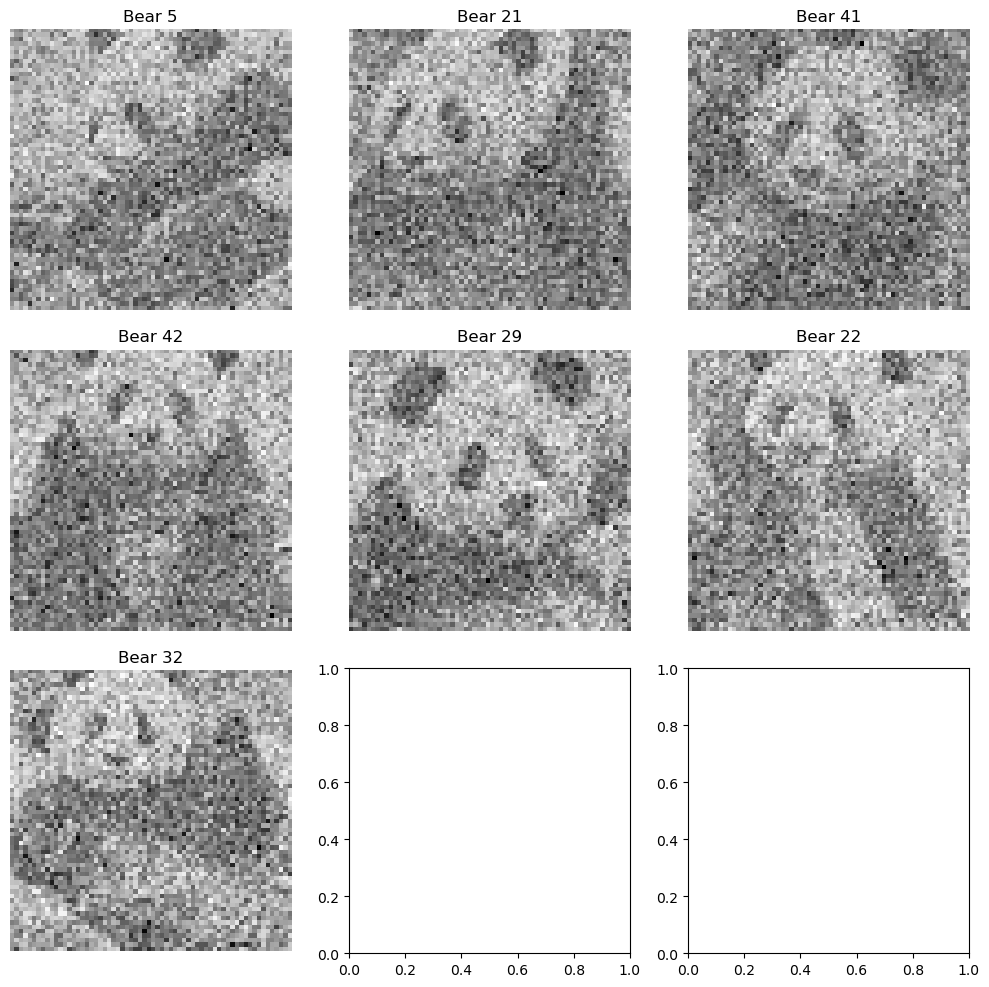

In [11]:
# Show hard-to-classify bears
# Let's take several most miscalssified bears from the table printed out above

bears_of_interest = [5, 21, 41, 42, 29, 22, 32]
# Create a grid of subplots
num_images = len(bears_of_interest)
num_cols = 3  # Adjust the number of columns as needed
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over each bear of interest and plot its image
for idx, bear_idx in enumerate(bears_of_interest):
    row = idx // num_cols
    col = idx % num_cols
    axes[row, col].imshow(test_images[bear_idx][::2, ::2], cmap='Greys_r')
    axes[row, col].set_title(f'Bear {bear_idx}')
    axes[row, col].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

I think these images are most miscalssified because either the bear is not in "portrait mode" and we can see a lot of its body, or it is looking to the side, etc.

# Part 4: Parametric classification

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [13]:
#Logistic Regression
logReg = LogisticRegression()
logReg.fit(X.T, y_train)
test_results = logReg.predict(Y.T)

accuracy = accuracy_score(y_test, test_results)
precision = precision_score(y_test, test_results)
recall = recall_score(y_test, test_results)
f1 = f1_score(y_test, test_results)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Accuracy: 0.9900
Precision: 0.9804
Recall: 1.0000
F1-score: 0.9901


In [14]:
#LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X.T, y_train)
test_results_lda = lda.predict(Y.T)

accuracy = accuracy_score(y_test, test_results_lda)
precision = precision_score(y_test, test_results_lda)
recall = recall_score(y_test, test_results_lda)
f1 = f1_score(y_test, test_results_lda)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.9900
Precision: 0.9804
Recall: 1.0000
F1-score: 0.9901


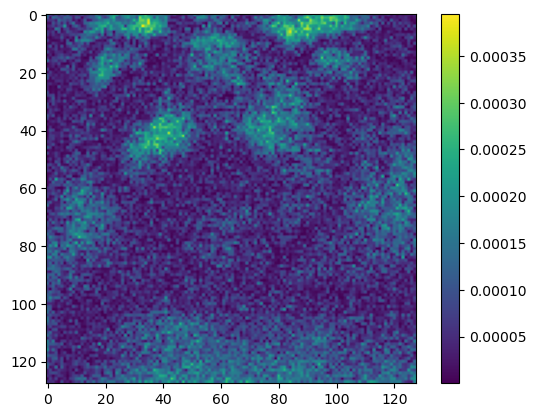

In [15]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((logReg.coef_).reshape((128,128))))
plt.colorbar()

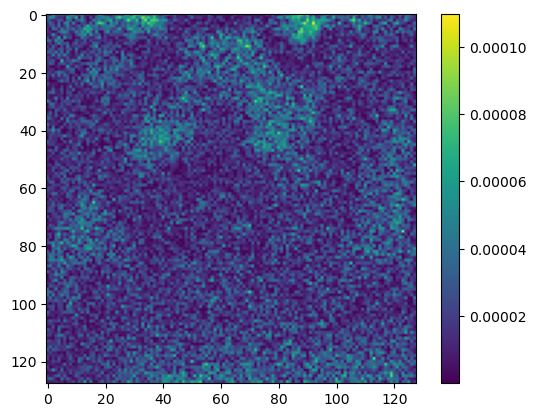

In [16]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((lda.coef_).reshape((128,128))))
plt.colorbar()

I am surprised that LDA performs as well as Linear Regression, given that Linear Regression model bear mask is more pronounced. I can identify ears, eyes/eyebrows, nose, and general face roundness, while in LDA I can only see ears and sort of forehead of a bear in the mask.

### Part 5 

Reran the code with noise set to True. 

* The perfomance of Linear Regression and LDA models drops down slightly. (This is expected.)
* LDA bear mask becomes more pronounced. 
* The eigenbears are more smoothed out, and look more like ghosts due to all the noise.